In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
# from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

## CreatingVGG16 from Scratch

## File paths

In [10]:
data ='/kaggle/input/stable-diffusion-image-to-prompts'
working='/kaggle/working'

## Model for image feature extraction

In [9]:
# model = VGG16()
import tensorflow
# model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
vgg = tensorflow.keras.applications.vgg16.VGG16(weights='/kaggle/input/vggweights/vgg16_weights_tf_dim_ordering_tf_kernels (1).h5')
# WEIGHTS_PATH_NO_TOP = ('https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')
# vgg = tensorflow.keras.applications.vgg16.VGG16(weights=WEIGHTS_PATH_NO_TOP)
model = Model(inputs=vgg.inputs, outputs=vgg.layers[-2].output)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Extracting Image features 

In [12]:

features = {}
directory = os.path.join(data, 'images')

for img_name in tqdm(os.listdir(directory)):
  
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))

    image = img_to_array(image)

    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    image = tensorflow.keras.applications.vgg16.preprocess_input(image)

    feature = model.predict(image, verbose=0)

    image_id = img_name.split('.')[0]

    features[image_id] = feature

  0%|          | 0/7 [00:00<?, ?it/s]

## Saving and loading saved features

In [13]:
pickle.dump(features, open(os.path.join(working, 'features.pkl'), 'wb'))

In [15]:
with open(os.path.join(working, 'features.pkl'), 'rb') as f:features = pickle.load(f)

## Loading captions and mapping with the image

In [16]:
with open(os.path.join(data, 'prompts.csv'), 'r') as f:
    next(f)
    captions_doc = f.read()
    

In [17]:

mapping = {}

for line in tqdm(captions_doc.split('\n')):
	tokens = line.split(',')
    
	if len(line) < 2:
		continue
        
	image_id, caption = tokens[0], tokens[1:]
	image_id = image_id.split('.')[0]
	caption = " ".join(caption)
    
	if image_id not in mapping:
		mapping[image_id] = []

	mapping[image_id].append(caption)

  0%|          | 0/8 [00:00<?, ?it/s]

In [18]:
len(mapping)

7

## Cleaning captions for model training

In [19]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):

            caption = captions[i]

            caption = caption.lower()

            caption = caption.replace('"', '')
            caption = caption.replace("\'s", ' is')
#             caption = caption.replace('', ' ')

            caption = 'start  ' + " ".join([word for word in caption.split() if len(word)>1]) + '  end'
            captions[i] = caption

In [20]:
mapping['20057f34d']

['hyper realistic photo of very friendly and dystopian crater']

In [21]:
clean(mapping)

In [22]:
mapping

{'20057f34d': ['start  hyper realistic photo of very friendly and dystopian crater  end'],
 '227ef0887': ['start  ramen carved out of fractal rose ebony in the style of hudson river school  end'],
 '92e911621': ['start  ultrasaurus holding black bean taco in the woods near an identical cheneosaurus  end'],
 'a4e1c55a9': ['start  thundering retro robot crane inks on parchment with droopy french bulldog  end'],
 'c98f79f71': ['start  portrait painting of shimmering greek hero next to loud frill-necked lizard  end'],
 'd8edf2e40': ['start  an astronaut standing on engaging white rose in the midst of by ivory cherry blossoms  end'],
 'f27825b2c': ['start  kaggle employee phil at donut shop ordering all the best donuts with speech bubble that proclaims donuts. it is what is for dinner!  end']}

In [23]:
all_captions = []
for key in mapping:
	for caption in mapping[key]:
		all_captions.append(caption)

In [24]:
len(all_captions)


7

In [25]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

84

In [26]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

25

## Train and Test split

In [27]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

##  Data generator 

In [28]:

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
  
	X1, X2, y = list(), list(), list()
	n = 0
	while 1:
		for key in data_keys:
			n += 1
			captions = mapping[key]
			for caption in captions:
				seq = tokenizer.texts_to_sequences([caption])[0]
				for i in range(1, len(seq)):
					in_seq, out_seq = seq[:i], seq[i]
					in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
					out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
					X1.append(features[key][0])
					X2.append(in_seq)
					y.append(out_seq)
			if n == batch_size:
				X1, X2, y = np.array(X1), np.array(X2), np.array(y)
				yield [X1, X2], y
				X1, X2, y = list(), list(), list()
				n = 0

## Model creation

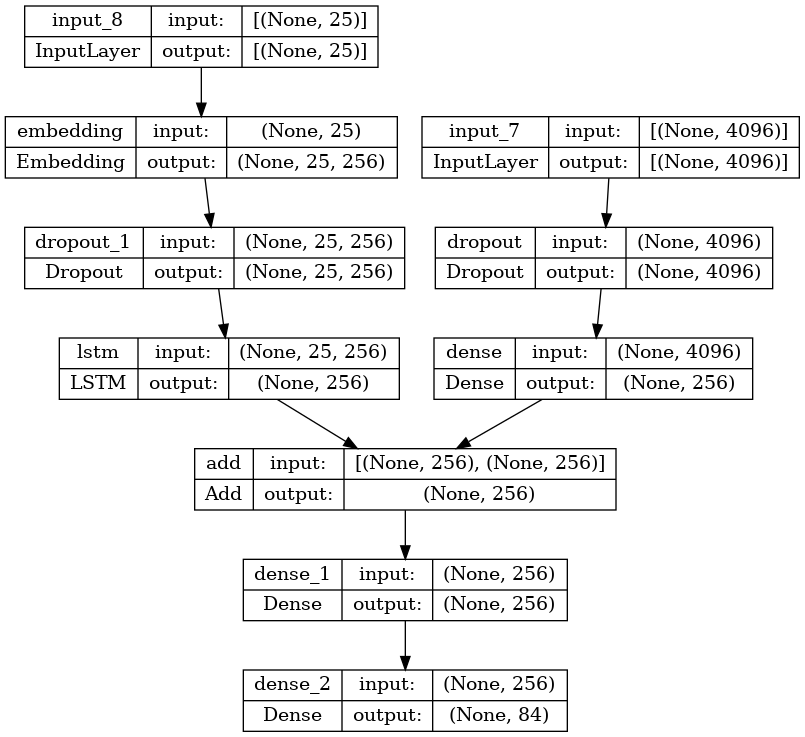

In [29]:
# encoder model
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)


# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
 
# plot the model
plot_model(model, show_shapes=True)

## Traing the Model

In [30]:
epochs = 100
batch_size = 1
steps = len(train) // batch_size

for i in range(epochs):
	generator = data_generator(image_ids, mapping, features, tokenizer, max_length, vocab_size, batch_size)
	model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

6/6 [==============================] - 0s 71ms/step - loss: 0.0613


In [31]:
model.save(working +'/best_model.h5')

## Caption generator

In [32]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
        	return word
    return None


In [33]:

def predict_caption(model, image, tokenizer, max_length):
	in_text = 'start'

	for i in range(max_length):
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		sequence = pad_sequences([sequence], max_length)
		text = model.predict([image, sequence], verbose=0)
		text = np.argmax(text)
		word = idx_to_word(text, tokenizer)
		if word is None:
			break
		in_text += " " + word
		if word == 'end':
			break

	return in_text

#  Validating

In [34]:
from nltk.translate.bleu_score import corpus_bleu
actual, predicted = list(), list()

for key in tqdm(test):
	captions = mapping[key]
	y_pred = predict_caption(model, features[key], tokenizer, max_length)
	actual_captions = [caption.split() for caption in captions]
	y_pred = y_pred.split()
	actual.append(actual_captions)
	predicted.append(y_pred)
    
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/1 [00:00<?, ?it/s]

BLEU-1: 0.091683
BLEU-2: 0.190854


/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


## Output testing

In [49]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(data, "images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    return y_pred
# 	plt.imshow(image)

---------------------Actual---------------------
start  hyper realistic photo of very friendly and dystopian crater  end
--------------------Predicted--------------------
start hyper realistic photo of very friendly and dystopian crater end


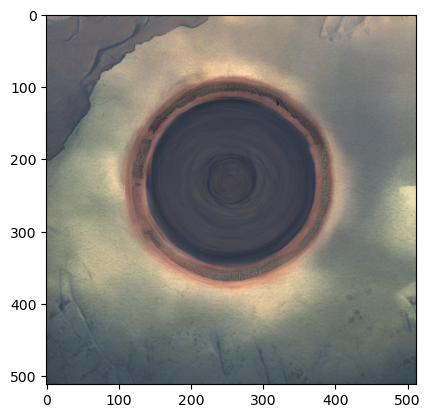

In [39]:
generate_caption("20057f34d.png")

#  Testing real image

In [ ]:
# image_path = '/kaggle/input/image25/image25.jpg'

# image1 = load_img(image_path, target_size=(224, 224))
# image = img_to_array(image1)
# image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# image = preprocess_input(image)

# feature = vgg_model.predict(image, verbose=0)

# x=predict_caption(model, feature, tokenizer, max_length)

# plt.imshow(image1)
# print(x)

In [40]:
import os
import sys
import numpy as np
import pandas as pd
from pathlib import Path

sys.path.append('../input/sentence-transformers-222/sentence-transformers')
from sentence_transformers import SentenceTransformer, models

comp_path = Path('/kaggle/input/stable-diffusion-image-to-prompts/')

In [41]:
sample_submission = pd.read_csv(comp_path / 'sample_submission.csv', index_col='imgId_eId')
sample_submission.head()

,val
imgId_eId,
20057f34d_0,0.018848
20057f34d_1,0.030190
20057f34d_2,0.072792
20057f34d_3,-0.000673
20057f34d_4,0.016774


In [42]:
images = os.listdir(comp_path / 'images')
imgIds = [i.split('.')[0] for i in images]

EMBEDDING_LENGTH = 384
eIds = list(range(EMBEDDING_LENGTH))

imgId_eId = [
    '_'.join(map(str, i)) for i in zip(
        np.repeat(imgIds, EMBEDDING_LENGTH),
        np.tile(range(EMBEDDING_LENGTH), len(imgIds)))]

assert sorted(imgId_eId) == sorted(sample_submission.index)

In [43]:
st_model = SentenceTransformer('/kaggle/input/sentence-transformers-222/all-MiniLM-L6-v2')


In [50]:
prompts = []
for key in mapping:
	for caption in mapping[key]:
		prompts.append(generate_caption(key+'.png'))
prompts

---------------------Actual---------------------
start  hyper realistic photo of very friendly and dystopian crater  end
--------------------Predicted--------------------
start hyper realistic photo of very friendly and dystopian crater end
---------------------Actual---------------------
start  ramen carved out of fractal rose ebony in the style of hudson river school  end
--------------------Predicted--------------------
start ramen carved out of fractal rose ebony in the style of hudson river school end
---------------------Actual---------------------
start  ultrasaurus holding black bean taco in the woods near an identical cheneosaurus  end
--------------------Predicted--------------------
start ultrasaurus holding black bean taco in the woods near an identical cheneosaurus end
---------------------Actual---------------------
start  thundering retro robot crane inks on parchment with droopy french bulldog  end
--------------------Predicted--------------------
start thundering retro

['start hyper realistic photo of very friendly and dystopian crater end',
 'start ramen carved out of fractal rose ebony in the style of hudson river school end',
 'start ultrasaurus holding black bean taco in the woods near an identical cheneosaurus end',
 'start thundering retro robot crane inks on parchment with droopy french bulldog end',
 'start portrait painting of shimmering greek hero next to loud frill necked lizard end',
 'start an astronaut standing on engaging white rose in the midst of by ivory cherry blossoms end',
 'start retro standing of of rose rose in the midst of frill end']

In [51]:
def clean2(prompts):
    for i in range(len(prompts)):
        prompt = prompts[i]
        prompt = prompt.replace('start', '')
        prompt = prompt.replace('end', '')
        prompts[i] = prompt
clean2(prompts)

In [52]:
prompts

[' hyper realistic photo of very frily and dystopian crater ',
 ' ramen carved out of fractal rose ebony in the style of hudson river school ',
 ' ultrasaurus holding black bean taco in the woods near an identical cheneosaurus ',
 ' thundering retro robot crane inks on parchment with droopy french bulldog ',
 ' portrait painting of shimmering greek hero next to loud frill necked lizard ',
 ' an astronaut standing on engaging white rose in the midst of by ivory cherry blossoms ',
 ' retro standing of of rose rose in the midst of frill ']

In [53]:
# prompts = ['All work and no Kaggle makes Jack a dull boy'] * len(images)
prompt_embeddings = st_model.encode(prompts).flatten()

submission = pd.DataFrame(
                index=imgId_eId,
                data=prompt_embeddings,
                columns=['val']).rename_axis('imgId_eId')

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [54]:
submission.to_csv('submission.csv')